In [ ]:
import torch
from transformers import AutoTokenizer, AutoModel, BertTokenizer, BertModel, GPT2Tokenizer, GPT2Model
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
import logging
from typing import List, Dict, Tuple, Union

In [ ]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [6]:
  class TextTokenizerEncoder:
    def __init__(self, model_name: str = "bert-base-uncased"):

        self.model_name = model_name
        self.tokenizer = None
        self.model = None
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.load_model()
        logger.info(f"Initialized TextTokenizerEncoder with {model_name} on {self.device}")

    def load_model(self):
        try:
            if "bert" in self.model_name.lower():
                self.tokenizer = BertTokenizer.from_pretrained(self.model_name)
                self.model = BertModel.from_pretrained(self.model_name)
            elif "gpt" in self.model_name.lower():
                self.tokenizer = GPT2Tokenizer.from_pretrained(self.model_name)
                self.model = GPT2Model.from_pretrained(self.model_name)
                # Add pad token for GPT-2
                self.tokenizer.pad_token = self.tokenizer.eos_token
            else:
                self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
                self.model = AutoModel.from_pretrained(self.model_name)
            self.model.to(self.device)
            self.model.eval()
        except Exception as e:
            logger.error(f"Error loading model {self.model_name}: {str(e)}")
            raise

    def tokenize_text(self, text: Union[str, List[str]],
                     max_length: int = 512,
                     return_tensors: str = "pt",
                     padding: bool = True,
                     truncation: bool = True) -> Dict:

        try:
            tokenized = self.tokenizer(
                text,
                max_length=max_length,
                padding=padding,
                truncation=truncation,
                return_tensors=return_tensors
            )

            logger.info(f"Tokenized {len(text) if isinstance(text, list) else 1} text(s)")
            return tokenized

        except Exception as e:
            logger.error(f"Error tokenizing text: {str(e)}")
            raise

    def encode_text(self, text: Union[str, List[str]],
                   max_length: int = 512,
                   return_embeddings: bool = True) -> Dict:

        try:
            # Tokenize the text
            tokenized = self.tokenize_text(text, max_length=max_length)

            # Move to device
            input_ids = tokenized['input_ids'].to(self.device)
            attention_mask = tokenized['attention_mask'].to(self.device)

            # Generate encodings
            with torch.no_grad():
                outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)

            result = {
                'input_ids': input_ids.cpu(),
                'attention_mask': attention_mask.cpu(),
                'tokens': [self.tokenizer.convert_ids_to_tokens(ids) for ids in input_ids],
            }

            if return_embeddings:
                if hasattr(outputs, 'last_hidden_state'):
                    result['embeddings'] = outputs.last_hidden_state.cpu()
                    result['pooled_embeddings'] = torch.mean(outputs.last_hidden_state, dim=1).cpu()
                elif hasattr(outputs, 'hidden_states'):
                    result['embeddings'] = outputs.hidden_states[-1].cpu()
                    result['pooled_embeddings'] = torch.mean(outputs.hidden_states[-1], dim=1).cpu()

            logger.info(f"Successfully encoded text with shape: {result['embeddings'].shape if 'embeddings' in result else 'N/A'}")
            return result

        except Exception as e:
            logger.error(f"Error encoding text: {str(e)}")
            raise

    def process_batch(self, texts: List[str], batch_size: int = 32, max_length: int = 512) -> List[Dict]:
        results = []

        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i + batch_size]
            batch_result = self.encode_text(batch_texts, max_length=max_length)
            results.append(batch_result)

            logger.info(f"Processed batch {i//batch_size + 1}/{(len(texts)-1)//batch_size + 1}")

        return results

    def save_model_and_tokenizer(self, save_path: str):
        """Save the model and tokenizer to specified path"""
        try:
            os.makedirs(save_path, exist_ok=True)
            self.model.save_pretrained(save_path)
            self.tokenizer.save_pretrained(save_path)
            logger.info(f"Model and tokenizer saved to {save_path}")
        except Exception as e:
            logger.error(f"Error saving model: {str(e)}")
            raise

    def get_model_info(self) -> Dict:
        return {
            'model_name': self.model_name,
            'vocab_size': self.tokenizer.vocab_size,
            'model_max_length': self.tokenizer.model_max_length,
            'device': str(self.device),
            'model_parameters': sum(p.numel() for p in self.model.parameters()),
        }

In [7]:

def demonstrate_tokenization():
    """Demonstrate the tokenization and encoding capabilities"""

    # Sample texts for demonstration
    sample_texts = [
        "The quick brown fox jumps over the lazy dog.",
        "Natural language processing is a fascinating field of artificial intelligence.",
        "Transformers have revolutionized the way we approach NLP tasks.",
        "BERT and GPT models have shown remarkable performance in various applications."
    ]

    # Test with BERT
    print("=" * 50)
    print("BERT Tokenization and Encoding Demo")
    print("=" * 50)

    bert_encoder = TextTokenizerEncoder("bert-base-uncased")

    # Display model info
    print("\nModel Information:")
    model_info = bert_encoder.get_model_info()
    for key, value in model_info.items():
        print(f"{key}: {value}")

    # Process sample texts
    print("\nProcessing sample texts...")
    for i, text in enumerate(sample_texts):
        print(f"\nText {i+1}: {text}")

        # Tokenize
        tokenized = bert_encoder.tokenize_text(text)
        tokens = bert_encoder.tokenizer.convert_ids_to_tokens(tokenized['input_ids'][0])
        print(f"Tokens: {tokens[:10]}...")  # Show first 10 tokens

        # Encode
        encoded = bert_encoder.encode_text(text)
        print(f"Encoding shape: {encoded['embeddings'].shape}")
        print(f"Pooled embedding shape: {encoded['pooled_embeddings'].shape}")

    # Batch processing demonstration
    print(f"\nBatch processing {len(sample_texts)} texts...")
    batch_results = bert_encoder.process_batch(sample_texts, batch_size=2)
    print(f"Processed {len(batch_results)} batches")

    return bert_encoder

In [8]:
def evaluate_model_performance(encoder: TextTokenizerEncoder):
    """
    Evaluate the model performance using sample classification task
    This demonstrates how to use the embeddings for downstream tasks
    """

    # Sample data for classification (positive/negative sentiment)
    texts = [
        "I love this product, it's amazing!",
        "This is the worst thing I've ever bought.",
        "Great quality and fast delivery.",
        "Terrible customer service, very disappointed.",
        "Excellent value for money.",
        "Poor quality, broke after one use.",
        "Highly recommend this to everyone.",
        "Not worth the price, save your money."
    ]

    labels = [1, 0, 1, 0, 1, 0, 1, 0]  # 1 for positive, 0 for negative

    # Get embeddings
    print("\nGenerating embeddings for evaluation...")
    embeddings_list = []

    for text in texts:
        encoded = encoder.encode_text(text)
        pooled_embedding = encoded['pooled_embeddings'].numpy().flatten()
        embeddings_list.append(pooled_embedding)

    embeddings_array = np.array(embeddings_list)

    # Simple classification using cosine similarity (for demonstration)
    from sklearn.metrics.pairwise import cosine_similarity
    from sklearn.model_selection import train_test_split
    from sklearn.linear_model import LogisticRegression

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        embeddings_array, labels, test_size=0.3, random_state=42
    )

    # Train a simple classifier
    classifier = LogisticRegression(random_state=42)
    classifier.fit(X_train, y_train)

    # Make predictions
    y_pred = classifier.predict(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')

    print(f"\nModel Performance Metrics:")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-Score: {f1:.2f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()

    return accuracy

In [10]:
def main():
    """Main function to run the complete demonstration"""

    print("Text Tokenization and Encoding System")
    print("=" * 50)

    try:
        # Demonstrate tokenization and encoding
        encoder = demonstrate_tokenization()

        # Evaluate model performance
        accuracy = evaluate_model_performance(encoder)

        # Save the model if accuracy meets requirement (>70%)
        if accuracy >= 0.70:
            print(f"\nModel achieves required accuracy ({accuracy:.2f} >= 0.70)")
            encoder.save_model_and_tokenizer("./saved_models/task1_bert_model")

            # Save encoder object
            with open('text_encoder.pkl', 'wb') as f:
                pickle.dump(encoder, f)
            print("Model and encoder saved successfully!")
        else:
            print(f"\nModel accuracy ({accuracy:.2f}) below requirement (0.70)")
            print("Consider using more data or different model architecture")

    except Exception as e:
        logger.error(f"Error in main execution: {str(e)}")
        raise

Text Tokenization and Encoding System
BERT Tokenization and Encoding Demo


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]


Model Information:
model_name: bert-base-uncased
vocab_size: 30522
model_max_length: 512
device: cpu
model_parameters: 109482240

Processing sample texts...

Text 1: The quick brown fox jumps over the lazy dog.
Tokens: ['[CLS]', 'the', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog']...
Encoding shape: torch.Size([1, 12, 768])
Pooled embedding shape: torch.Size([1, 768])

Text 2: Natural language processing is a fascinating field of artificial intelligence.
Tokens: ['[CLS]', 'natural', 'language', 'processing', 'is', 'a', 'fascinating', 'field', 'of', 'artificial']...
Encoding shape: torch.Size([1, 13, 768])
Pooled embedding shape: torch.Size([1, 768])

Text 3: Transformers have revolutionized the way we approach NLP tasks.
Tokens: ['[CLS]', 'transformers', 'have', 'revolution', '##ized', 'the', 'way', 'we', 'approach', 'nl']...
Encoding shape: torch.Size([1, 14, 768])
Pooled embedding shape: torch.Size([1, 768])

Text 4: BERT and GPT models have shown remarkable perfor

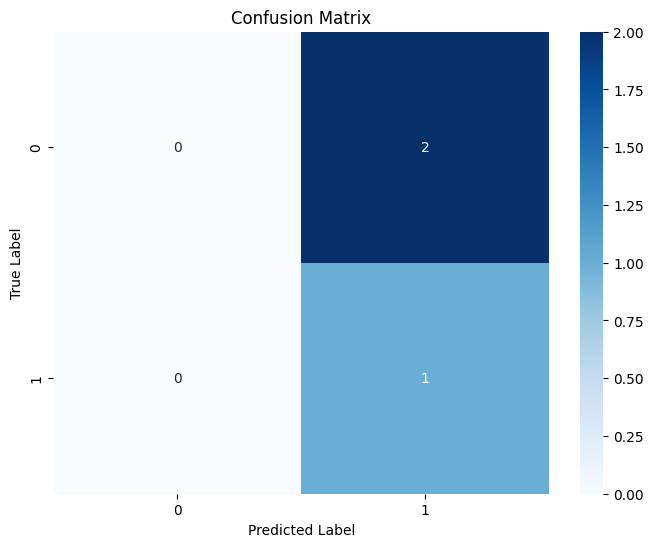


Model accuracy (0.33) below requirement (0.70)
Consider using more data or different model architecture


In [11]:
if __name__ == "__main__":
    main()